In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   

Mounted at /content/drive


In [ ]:
import pathlib

training_data ="Data Path"
data_dir = pathlib.Path(training_data)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

283


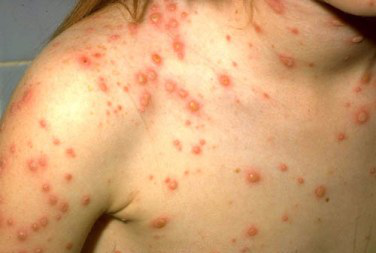

In [ ]:
roses = list(data_dir.glob('Chickenpox/*'))
PIL.Image.open(str(roses[0]))

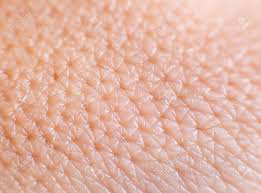

In [ ]:
roses = list(data_dir.glob('Normal_Skin/*'))
PIL.Image.open(str(roses[1]))

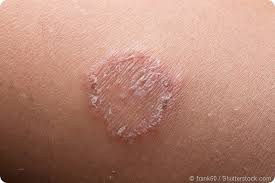

In [ ]:
roses = list(data_dir.glob('Ringworm/*'))
PIL.Image.open(str(roses[8]))

In [ ]:
batch_size = 10
img_height = 200
img_width = 200

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 283 files belonging to 5 classes.
Using 255 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 283 files belonging to 5 classes.
Using 28 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Chickenpox', 'Normal_Skin', 'Normal_eye', 'PinkEye', 'Ringworm']


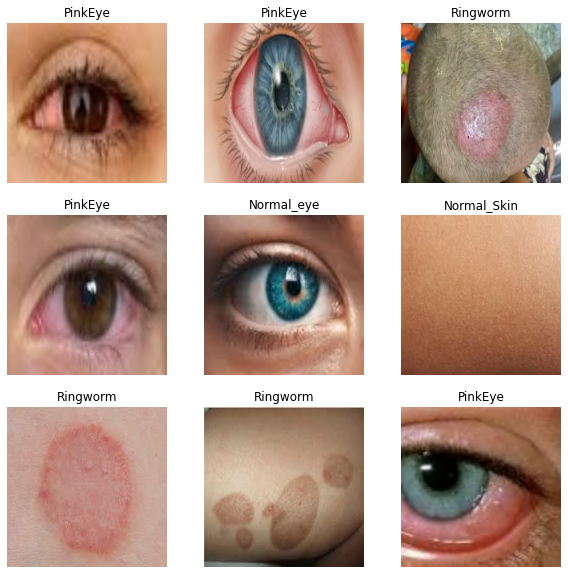

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 200, 200, 3)
(10,)


In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.99945045


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Data Augmentation 

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


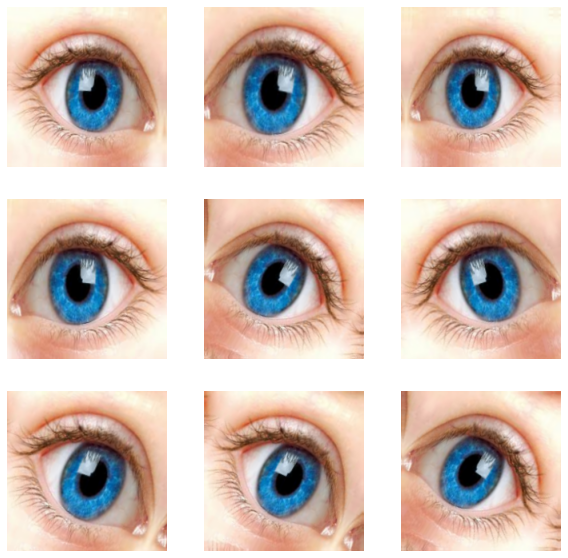

In [ ]:
# Visualize Augmented images 

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(12):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
26/26 [==============================] - 31s 1s/step - loss: 2.3317 - accuracy: 0.2166 - val_loss: 1.6980 - val_accuracy: 0.4643
Epoch 2/10
26/26 [==============================] - 12s 460ms/step - loss: 1.2969 - accuracy: 0.4401 - val_loss: 0.8793 - val_accuracy: 0.7500
Epoch 3/10
26/26 [==============================] - 12s 460ms/step - loss: 0.8928 - accuracy: 0.6254 - val_loss: 0.6797 - val_accuracy: 0.8214
Epoch 4/10
26/26 [==============================] - 12s 456ms/step - loss: 0.8466 - accuracy: 0.6070 - val_loss: 0.7633 - val_accuracy: 0.7857
Epoch 5/10
26/26 [==============================] - 12s 456ms/step - loss: 0.9036 - accuracy: 0.6235 - val_loss: 0.6506 - val_accuracy: 0.8571
Epoch 6/10
26/26 [==============================] - 12s 456ms/step - loss: 0.6476 - accuracy: 0.7288 - val_loss: 0.5260 - val_accuracy: 0.8571
Epoch 7/10
26/26 [==============================] - 12s 458ms/step - loss: 0.6228 - accuracy: 0.6815 - val_loss: 0.6025 - val_accuracy: 0.8214
Ep

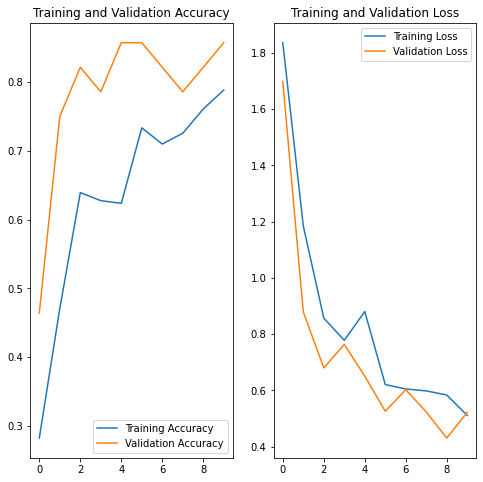

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()